In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [105]:
def highlight_intersection(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Error: Less than two contours found.")
        return

    # Assuming the two largest contours are the pencils
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Create an empty mask
    mask = np.zeros_like(gray)

    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    # Find the intersection area
    intersection_mask = np.zeros_like(gray)
    cv2.drawContours(intersection_mask, contours, -1, 255, thickness=cv2.FILLED)
    intersection = cv2.bitwise_and(intersection_mask, intersection_mask, mask=mask)

    # Find contours of the intersection area
    intersection_contours, _ = cv2.findContours(intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no intersection contours found, exit
    if not intersection_contours:
        print("Error: No intersection area found.")
        return

    # Find the smallest contour which is likely to be the actual intersection point
    smallest_contour = min(intersection_contours, key=cv2.contourArea)

    # Highlight the intersection area
    x, y, w, h = cv2.boundingRect(smallest_contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Optional: Draw a circle at the center of the intersection area
    center_x, center_y = x + w // 2, y + h // 2
    cv2.circle(image, (center_x, center_y), 10, (0, 0, 255), -1)

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    denoised_image = cv2.medianBlur(image_rgb, 3)

    return denoised_image


In [106]:
def calculate_lengths_and_angles(image_path):

  # Load the image
  image = cv2.imread(image_path)

  denoised_image = cv2.medianBlur(image, 3)

  # Edge detection
  edges = cv2.Canny(denoised_image, 50, 150, apertureSize=3)

  # Hough Line Transform to detect lines
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

  # Draw lines and calculate lengths
  lengths = []
  angles = []
  for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(denoised_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
      length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
      lengths.append(length)
      angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
      angles.append(angle)

  # Assuming lengths[0] is pencil A and lengths[1] is pencil B
  length_a_mm = lengths[0] * 0.1
  length_b_mm = lengths[1] * 0.1

  # Calculate angle between the two pencils
  angle_between_pencils = np.abs(angles[0] - angles[1])

  return length_a_mm, length_b_mm, angle_between_pencils


Length of Pencil A: 23.49 mm
Length of Pencil B: 23.41 mm
Angle between the pencils:  0.14 degrees


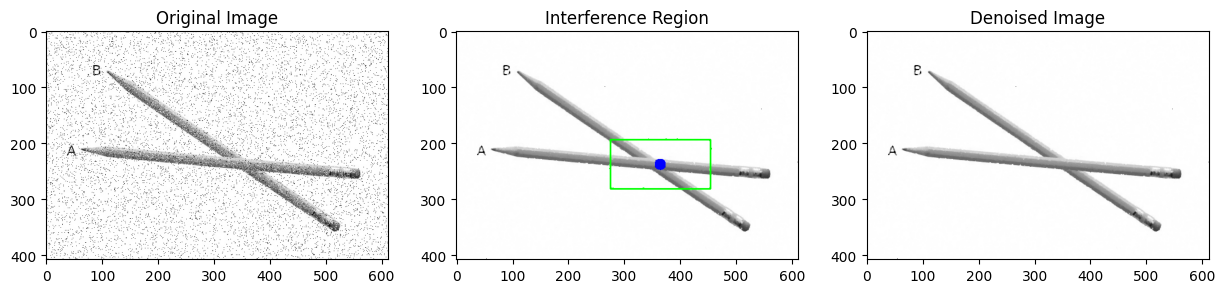

In [108]:
img_path = 'pencils.jpg'
image = cv2.imread(img_path)
intersected_image = highlight_intersection(img_path)
DI = cv2.medianBlur(image, 3)

length_a_mm,length_b_mm,angle_between_pencils = calculate_lengths_and_angles(img_path)

# Display the results
print(f"Length of Pencil A:{length_a_mm: .2f} mm")
print(f"Length of Pencil B:{length_b_mm: .2f} mm")
print(f"Angle between the pencils: {angle_between_pencils: .2f} degrees")

# Display the original, line-detected images and denoised.
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title('Interference Region')
plt.imshow(cv2.cvtColor(intersected_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3 ,3)
plt.title('Denoised Image')
plt.imshow(cv2.cvtColor(DI, cv2.COLOR_BGR2RGB))

plt.show()
